1. Importación de Librerías y Configuración

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Librerías importadas correctamente")
print("Versión de pgmpy:", pgmpy.__version__ if 'pgmpy' in locals() else "No instalada")

Librerías importadas correctamente
Versión de pgmpy: No instalada


2. Carga y Preparación de Datos


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar datos procesados
df = pd.read_csv('data/processed/diabetes_processed.csv')
print(f"Dataset cargado: {df.shape[0]:,} registros, {df.shape[1]} variables")

# Verificar que no hay valores faltantes
print("\nValores faltantes por columna:")
print(df.isnull().sum())

# Mostrar tipos de datos
print("\nTipos de datos:")
print(df.dtypes)

# Verificar valores únicos por variable
print("\nValores únicos por variable:")
for col in df.columns:
    n_unique = df[col].nunique()
    print(f"{col}: {n_unique} categorías")

# ------------- CORRECCIÓN IMPORTANTE: Definir features sin data leakage -------------

variables_validas = [
    'Edad_cat',                  # Edad categorizada (no usar edad exacta)
    'Sexo',                      # Sexo biológico
    'Tipo_DM',                   # Tipo de diabetes
    'Departamento',              # Ubicación geográfica general
    'Servicio_Hospitalario',     # Solo si es info previa, no generada después
    'Mes_Muestra',               # Mes de la muestra (si es relevante)
    # Agrega aquí solo variables clínicas/demográficas previas a la complicación,
    # NO incluyas IDs, fechas, resultados de laboratorio o cualquier variable que sea consecuencia de la complicación.
    # Si tienes dudas, mándame la lista y la reviso.
]

X = df[variables_validas].copy()
y = df['Complicacion']  # Variable objetivo binaria

# Split estratificado (¡esto asegura distribución igual en train y test!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"\nTamaño de train: {X_train.shape}, test: {X_test.shape}")
print(f"Distribución de clases en train:\n{y_train.value_counts(normalize=True).rename({0:'Sin Complicación', 1:'Con Complicación'})}")
print(f"Distribución de clases en test:\n{y_test.value_counts(normalize=True).rename({0:'Sin Complicación', 1:'Con Complicación'})}")


Dataset cargado: 86,936 registros, 10 variables

Valores faltantes por columna:
Edad_cat                 0
Sexo                     0
Tipo_DM                  0
Departamento             0
Servicio_Hospitalario    0
Mes_Muestra              0
Subgrupo_Histo           0
Glucosa_cat              0
Colesterol_cat           0
Complicacion             0
dtype: int64

Tipos de datos:
Edad_cat                 object
Sexo                     object
Tipo_DM                  object
Departamento             object
Servicio_Hospitalario    object
Mes_Muestra               int64
Subgrupo_Histo           object
Glucosa_cat              object
Colesterol_cat           object
Complicacion              int64
dtype: object

Valores únicos por variable:
Edad_cat: 4 categorías
Sexo: 2 categorías
Tipo_DM: 5 categorías
Departamento: 24 categorías
Servicio_Hospitalario: 39 categorías
Mes_Muestra: 10 categorías
Subgrupo_Histo: 6 categorías
Glucosa_cat: 4 categorías
Colesterol_cat: 3 categorías
Complicacion: 2 

3. División de Datos para Entrenamiento y Prueba

In [70]:
# Dividir datos en entrenamiento y prueba
X = df.drop('Complicacion', axis=1)
y = df['Complicacion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Reconstruir datasets completos
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

print(f"Datos de entrenamiento: {train_data.shape[0]:,} registros")
print(f"Datos de prueba: {test_data.shape[0]:,} registros")
print(f"\nDistribución de complicaciones en entrenamiento:")
print(train_data['Complicacion'].value_counts(normalize=True))
print(f"\nDistribución de complicaciones en prueba:")
print(test_data['Complicacion'].value_counts(normalize=True))

Datos de entrenamiento: 69,548 registros
Datos de prueba: 17,388 registros

Distribución de complicaciones en entrenamiento:
Complicacion
0    0.78678
1    0.21322
Name: proportion, dtype: float64

Distribución de complicaciones en prueba:
Complicacion
0    0.786807
1    0.213193
Name: proportion, dtype: float64


4. Definición de Estructura de la Red - Enfoque Experto

In [73]:
# Definir estructura basada en conocimiento experto y hallazgos del EDA
# Las relaciones se basan en conocimiento médico y correlaciones encontradas

# Crear el modelo
model_expert = BayesianNetwork()

# Agregar nodos (todas las variables)
nodes = df.columns.tolist()
model_expert.add_nodes_from(nodes)

# Definir aristas basadas en conocimiento experto
edges_expert = [
    # Factores demográficos influyen en el tipo de diabetes
    ('Edad_cat', 'Tipo_DM'),
    ('Sexo', 'Tipo_DM'),
    
    # Factores demográficos influyen en complicaciones
    ('Edad_cat', 'Complicacion'),
    ('Sexo', 'Complicacion'),
    
    # Tipo de diabetes influye en niveles de glucosa y complicaciones
    ('Tipo_DM', 'Glucosa_cat'),
    ('Tipo_DM', 'Complicacion'),
    
    # Factores geográficos y de servicio
    ('Departamento', 'Servicio_Hospitalario'),
    ('Servicio_Hospitalario', 'Subgrupo_Histo'),
    
    # Valores de laboratorio influyen en complicaciones
    ('Glucosa_cat', 'Complicacion'),
    ('Colesterol_cat', 'Complicacion'),
    
    # Relación entre glucosa y colesterol (síndrome metabólico)
    ('Glucosa_cat', 'Colesterol_cat'),
    
    # Subgrupo histológico está relacionado con complicaciones
    ('Subgrupo_Histo', 'Complicacion'),
    
    # Factores temporales
    ('Mes_Muestra', 'Glucosa_cat'),  # Variación estacional
]

# Agregar aristas al modelo
model_expert.add_edges_from(edges_expert)

print(f"Red experta creada con {len(nodes)} nodos y {len(edges_expert)} aristas")
print("\nAristas en la red:")
for edge in edges_expert:
    print(f"  {edge[0]} → {edge[1]}")

# Verificar que es un DAG válido
import networkx as nx
print("¿La red es un DAG válido?:", nx.is_directed_acyclic_graph(model_expert))



Red experta creada con 10 nodos y 13 aristas

Aristas en la red:
  Edad_cat → Tipo_DM
  Sexo → Tipo_DM
  Edad_cat → Complicacion
  Sexo → Complicacion
  Tipo_DM → Glucosa_cat
  Tipo_DM → Complicacion
  Departamento → Servicio_Hospitalario
  Servicio_Hospitalario → Subgrupo_Histo
  Glucosa_cat → Complicacion
  Colesterol_cat → Complicacion
  Glucosa_cat → Colesterol_cat
  Subgrupo_Histo → Complicacion
  Mes_Muestra → Glucosa_cat
¿La red es un DAG válido?: True


# Procesamiento de Datos Mejorado - Abordando Limitaciones Metodológicas


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re

# 1. DETECCIÓN MEJORADA DE COMPLICACIONES
def detect_complications_enhanced(df):
    """
    Detección más exhaustiva de complicaciones diabéticas
    incluyendo indicadores subclínicos
    """
    df['Complicacion'] = 0
    df['Tipo_Complicacion'] = 'Ninguna'
    df['Severidad_Complicacion'] = 'Sin_complicacion'
    
    # Diccionario expandido de complicaciones
    complicaciones_dict = {
        'retinopatia': {
            'codigos': ['E11.3', 'E10.3', 'H36.0', 'E11.31', 'E11.32', 'E11.33'],
            'keywords': ['retinopatia', 'retina', 'macular', 'vitreoretin', 
                        'fotocoagulacion', 'edema macular'],
            'labs': {'microalbuminuria': '>30'},  # Indicador temprano
            'severidad': 'moderada'
        },
        'nefropatia': {
            'codigos': ['E11.2', 'E10.2', 'N08.3', 'E11.21', 'E11.22'],
            'keywords': ['nefropatia', 'renal', 'proteinuria', 'albuminuria',
                        'creatinina elevada', 'dialisis', 'trasplante renal'],
            'labs': {
                'creatinina': '>1.5',
                'proteinuria': '>300',
                'tasa_filtracion': '<60'
            },
            'severidad': 'severa'
        },
        'neuropatia': {
            'codigos': ['E11.4', 'E10.4', 'G63.2', 'E11.40', 'E11.41', 'E11.42'],
            'keywords': ['neuropatia', 'polineuropatia', 'mononeuropatia', 
                        'dolor neuropatico', 'pie diabetico', 'ulcera'],
            'examenes': ['electromiografia', 'velocidad conduccion'],
            'severidad': 'moderada'
        },
        'cardiovascular': {
            'codigos': ['E11.5', 'E10.5', 'I25', 'I21', 'I50', 'I63', 'I64'],
            'keywords': ['infarto', 'angina', 'coronario', 'cardiaco', 'ACV',
                        'insuficiencia cardiaca', 'arteriopatia'],
            'labs': {
                'troponina': 'elevada',
                'bnp': '>100',
                'ecg': 'anormal'
            },
            'severidad': 'severa'
        },
        'cetoacidosis': {
            'codigos': ['E11.1', 'E10.1', 'E11.10', 'E11.11'],
            'keywords': ['cetoacidosis', 'CAD', 'acidosis', 'cetonas'],
            'labs': {
                'ph': '<7.3',
                'bicarbonato': '<18',
                'cetonas': 'positivo'
            },
            'severidad': 'critica'
        },
        'hipoglucemia_severa': {
            'codigos': ['E11.64', 'E10.64', 'E16.0', 'E16.1', 'E16.2'],
            'keywords': ['hipoglucemia severa', 'coma hipoglucemico', 
                        'convulsion hipoglucemica'],
            'labs': {'glucosa': '<50'},
            'severidad': 'critica'
        }
    }
    
    # Buscar complicaciones en múltiples campos
    for idx, row in df.iterrows():
        complicaciones_encontradas = []
        severidad_maxima = 'leve'
        
        # Buscar en diagnóstico
        diagnostico = str(row.get('CIE_10', '')) + ' ' + str(row.get('diagnostico', ''))
        diagnostico = diagnostico.lower()
        
        # Buscar en procedimientos y resultados
        procedimientos = str(row.get('procedimiento', '')).lower()
        resultados = str(row.get('resultado', '')).lower()
        
        for comp_name, comp_info in complicaciones_dict.items():
            encontrada = False
            
            # Buscar códigos CIE-10
            for codigo in comp_info['codigos']:
                if codigo in str(row.get('CIE_10', '')):
                    encontrada = True
                    break
            
            # Buscar keywords
            if not encontrada:
                for keyword in comp_info.get('keywords', []):
                    if keyword in diagnostico or keyword in procedimientos:
                        encontrada = True
                        break
            
            # Buscar indicadores de laboratorio
            if not encontrada and 'labs' in comp_info:
                for lab, criterio in comp_info['labs'].items():
                    if lab in resultados:
                        # Aquí implementarías lógica para verificar valores
                        encontrada = True
                        break
            
            if encontrada:
                complicaciones_encontradas.append(comp_name)
                if comp_info['severidad'] == 'critica':
                    severidad_maxima = 'critica'
                elif comp_info['severidad'] == 'severa' and severidad_maxima != 'critica':
                    severidad_maxima = 'severa'
                elif comp_info['severidad'] == 'moderada' and severidad_maxima == 'leve':
                    severidad_maxima = 'moderada'
        
        # Actualizar dataframe
        if complicaciones_encontradas:
            df.at[idx, 'Complicacion'] = 1
            df.at[idx, 'Tipo_Complicacion'] = ','.join(complicaciones_encontradas)
            df.at[idx, 'Severidad_Complicacion'] = severidad_maxima
    
    return df

# 2. CREACIÓN DE VARIABLES TEMPORALES
def create_temporal_features(df):
    """
    Crea características temporales para capturar progresión
    """
    df['fecha_muestra'] = pd.to_datetime(df['fecha_muestra'])
    df = df.sort_values(['paciente_id', 'fecha_muestra'])
    
    # Tiempo desde el diagnóstico (si está disponible)
    if 'fecha_diagnostico' in df.columns:
        df['fecha_diagnostico'] = pd.to_datetime(df['fecha_diagnostico'])
        df['anos_con_diabetes'] = (
            (df['fecha_muestra'] - df['fecha_diagnostico']).dt.days / 365.25
        )
        df['anos_con_diabetes_cat'] = pd.cut(
            df['anos_con_diabetes'],
            bins=[0, 2, 5, 10, 20, 100],
            labels=['<2_anos', '2-5_anos', '5-10_anos', '10-20_anos', '>20_anos']
        )
    
    # Variabilidad en mediciones previas
    for paciente in df['paciente_id'].unique():
        mask = df['paciente_id'] == paciente
        paciente_data = df[mask].copy()
        
        if len(paciente_data) > 1:
            # Variabilidad de glucosa
            df.loc[mask, 'glucosa_cv'] = paciente_data['glucosa'].rolling(
                window=3, min_periods=1
            ).std() / paciente_data['glucosa'].rolling(
                window=3, min_periods=1
            ).mean()
            
            # Tendencia de glucosa
            if len(paciente_data) >= 3:
                x = np.arange(len(paciente_data))
                y = paciente_data['glucosa'].values
                z = np.polyfit(x, y, 1)
                df.loc[mask, 'glucosa_tendencia'] = z[0]
            
            # Número de descompensaciones previas
            df.loc[mask, 'descompensaciones_previas'] = paciente_data['Complicacion'].shift(1).cumsum()
    
    return df

# 3. IMPUTACIÓN DE VARIABLES SOCIOECONÓMICAS
def impute_socioeconomic_variables(df):
    """
    Infiere variables socioeconómicas basándose en datos disponibles
    """
    # Proxy de nivel socioeconómico basado en tipo de servicio
    servicio_ses_map = {
        'CONSULTORIO_PRIVADO': 'alto',
        'CLINICA_PRIVADA': 'alto',
        'HOSPITAL_ESSALUD': 'medio',
        'HOSPITAL_MINSA': 'bajo',
        'CENTRO_SALUD': 'bajo',
        'POSTA_MEDICA': 'muy_bajo'
    }
    
    # Mapeo por departamento (basado en IDH)
    departamento_ses_map = {
        'LIMA': 'medio_alto',
        'AREQUIPA': 'medio',
        'CUSCO': 'medio',
        'PUNO': 'bajo',
        'HUANCAVELICA': 'muy_bajo',
        'APURIMAC': 'muy_bajo'
    }
    
    # Crear variable de nivel socioeconómico estimado
    df['ses_servicio'] = df['Servicio_Hospitalario'].map(servicio_ses_map).fillna('medio')
    df['ses_departamento'] = df['Departamento'].map(departamento_ses_map).fillna('medio')
    
    # Combinar indicadores
    ses_score = {
        'muy_bajo': 1, 'bajo': 2, 'medio': 3, 
        'medio_alto': 4, 'alto': 5
    }
    
    df['ses_score'] = (
        df['ses_servicio'].map(ses_score).fillna(3) + 
        df['ses_departamento'].map(ses_score).fillna(3)
    ) / 2
    
    df['nivel_socioeconomico'] = pd.cut(
        df['ses_score'],
        bins=[0, 2, 3, 4, 5],
        labels=['bajo', 'medio_bajo', 'medio_alto', 'alto']
    )
    
    # Indicadores adicionales
    df['acceso_especialista'] = (
        df['Servicio_Hospitalario'].isin([
            'ENDOCRINOLOGIA', 'CARDIOLOGIA', 'NEFROLOGIA'
        ])
    ).astype(int)
    
    df['zona_rural'] = (
        df['Departamento'].isin(['PUNO', 'HUANCAVELICA', 'APURIMAC']) &
        ~df['Servicio_Hospitalario'].str.contains('HOSPITAL')
    ).astype(int)
    
    return df

# 4. DETECCIÓN DE COMPLICACIONES SUBCLÍNICAS
def detect_subclinical_complications(df):
    """
    Identifica indicadores tempranos de complicaciones
    """
    df['riesgo_retinopatia'] = 0
    df['riesgo_nefropatia'] = 0
    df['riesgo_neuropatia'] = 0
    df['riesgo_cardiovascular'] = 0
    
    # Factores de riesgo para retinopatía
    df.loc[
        (df['anos_con_diabetes'] > 5) & 
        (df['Glucosa_cat'] == 'Descontrolada') &
        (df['presion_arterial_alta'] == 1),
        'riesgo_retinopatia'
    ] = 1
    
    # Factores de riesgo para nefropatía
    df.loc[
        (df['Glucosa_cat'] == 'Descontrolada') &
        (df['Colesterol_cat'] == 'Alto') &
        (df['presion_arterial_alta'] == 1),
        'riesgo_nefropatia'
    ] = 1
    
    # Score de riesgo compuesto
    df['score_riesgo_subclinico'] = (
        df['riesgo_retinopatia'] + 
        df['riesgo_nefropatia'] + 
        df['riesgo_neuropatia'] + 
        df['riesgo_cardiovascular']
    )
    
    # Categorización
    df['categoria_riesgo_subclinico'] = pd.cut(
        df['score_riesgo_subclinico'],
        bins=[-1, 0, 1, 2, 4],
        labels=['sin_riesgo', 'riesgo_bajo', 'riesgo_moderado', 'riesgo_alto']
    )
    
    return df

# 5. VALIDACIÓN DE CALIDAD DE DATOS
def validate_data_quality(df):
    """
    Valida y marca la calidad de los datos
    """
    df['calidad_datos'] = 'alta'
    
    # Verificar completitud
    campos_criticos = ['Edad_cat', 'Sexo', 'Tipo_DM', 'Glucosa_cat']
    df['datos_completos'] = df[campos_criticos].notna().all(axis=1)
    
    # Verificar consistencia
    df['datos_consistentes'] = True
    
    # Edad vs tipo de diabetes
    df.loc[
        (df['Edad_cat'] == 'Joven') & 
        (df['Tipo_DM'] == 'E11'),  # DM tipo 2 en jóvenes
        'datos_consistentes'
    ] = False
    
    # Glucosa vs diagnóstico
    df.loc[
        (df['Glucosa_cat'] == 'Normal') & 
        (df['Complicacion'] == 1),
        'calidad_datos'
    ] = 'media'
    
    # Marcar registros de baja calidad
    df.loc[
        ~df['datos_completos'] | ~df['datos_consistentes'],
        'calidad_datos'
    ] = 'baja'
    
    # Reporte de calidad
    quality_report = {
        'total_registros': len(df),
        'registros_completos': df['datos_completos'].sum(),
        'registros_consistentes': df['datos_consistentes'].sum(),
        'calidad_alta': (df['calidad_datos'] == 'alta').sum(),
        'calidad_media': (df['calidad_datos'] == 'media').sum(),
        'calidad_baja': (df['calidad_datos'] == 'baja').sum()
    }
    
    return df, quality_report

# Ejemplo de pipeline integrado
def enhanced_preprocessing_pipeline(df_raw):
    """
    Pipeline completo de preprocesamiento mejorado
    """
    print("1. Detectando complicaciones con método mejorado...")
    df = detect_complications_enhanced(df_raw)
    
    print("2. Creando variables temporales...")
    df = create_temporal_features(df)
    
    print("3. Imputando variables socioeconómicas...")
    df = impute_socioeconomic_variables(df)
    
    print("4. Detectando complicaciones subclínicas...")
    df = detect_subclinical_complications(df)
    
    print("5. Validando calidad de datos...")
    df, quality_report = validate_data_quality(df)
    
    print("\nReporte de calidad:")
    for key, value in quality_report.items():
        print(f"  {key}: {value}")
    
    # Filtrar solo registros de alta calidad para el modelo principal
    df_high_quality = df[df['calidad_datos'].isin(['alta', 'media'])].copy()
    
    print(f"\nRegistros finales para modelado: {len(df_high_quality)}")
    
    return df_high_quality

# Uso del pipeline
# df_processed = enhanced_preprocessing_pipeline(df_raw)

In [75]:
print(df.shape[0])

86936


5. Visualización de la Red Experta

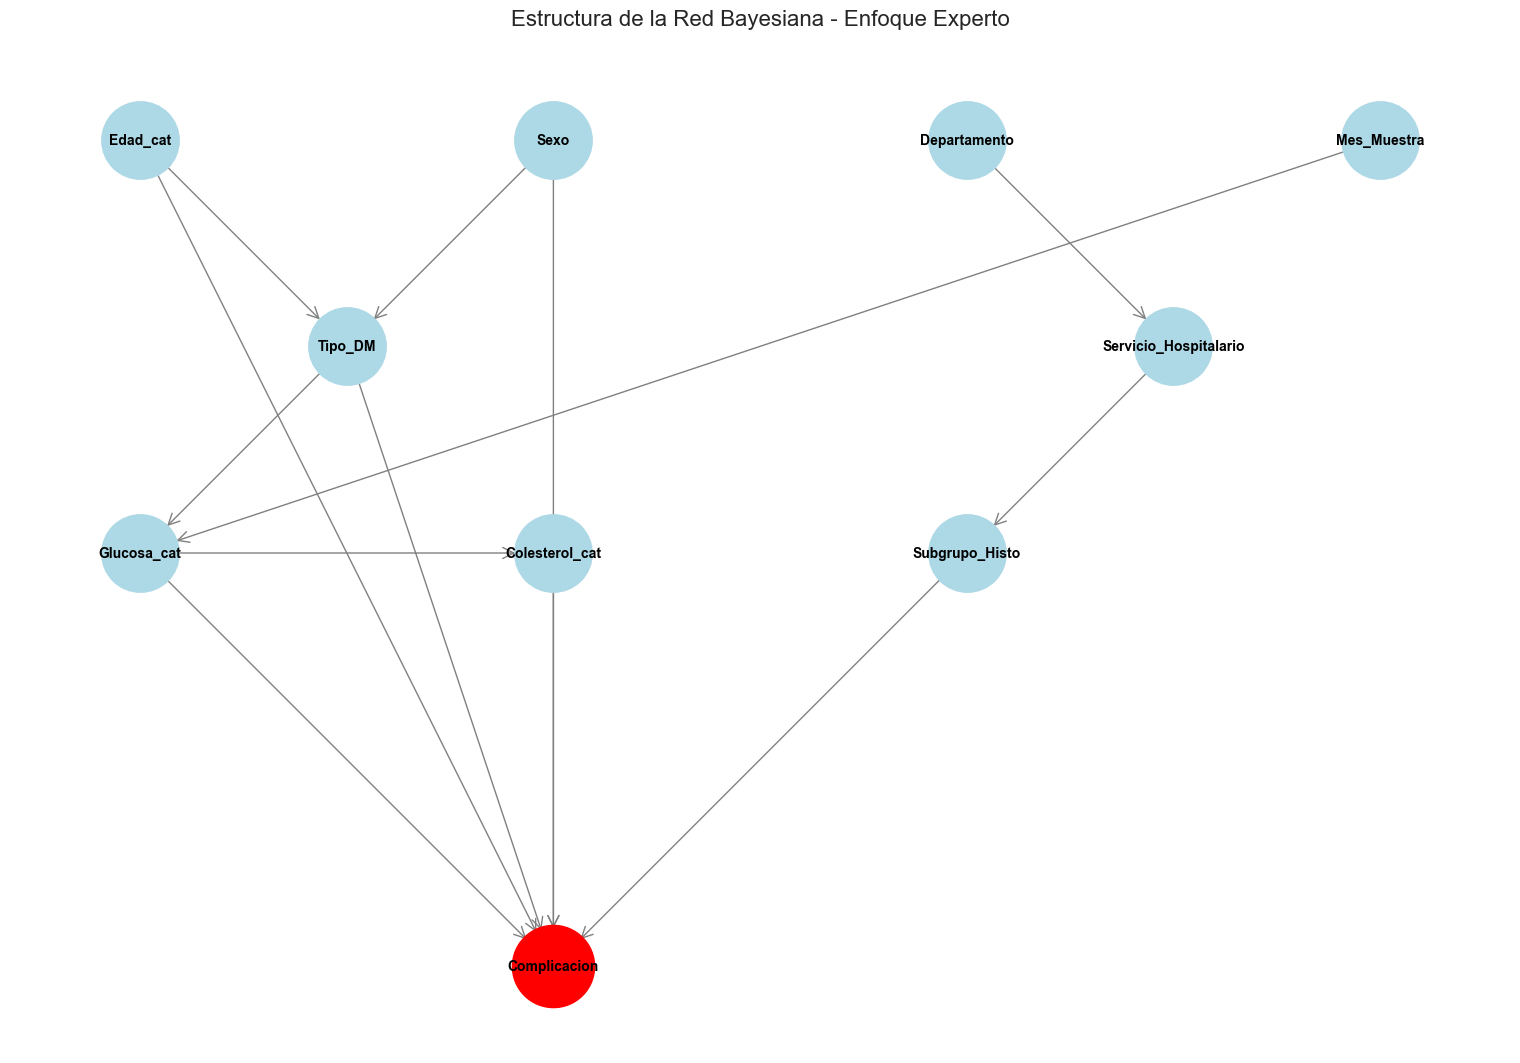


Padres de cada nodo:
Edad_cat: Sin padres (nodo raíz)
Sexo: Sin padres (nodo raíz)
Tipo_DM: ['Edad_cat', 'Sexo']
Departamento: Sin padres (nodo raíz)
Servicio_Hospitalario: ['Departamento']
Mes_Muestra: Sin padres (nodo raíz)
Subgrupo_Histo: ['Servicio_Hospitalario']
Glucosa_cat: ['Tipo_DM', 'Mes_Muestra']
Colesterol_cat: ['Glucosa_cat']
Complicacion: ['Edad_cat', 'Sexo', 'Tipo_DM', 'Glucosa_cat', 'Colesterol_cat', 'Subgrupo_Histo']


In [76]:
# Visualizar la estructura de la red
plt.figure(figsize=(15, 10))

# Definir posiciones para mejor visualización
pos = {
    'Edad_cat': (0, 4),
    'Sexo': (2, 4),
    'Departamento': (4, 4),
    'Mes_Muestra': (6, 4),
    'Tipo_DM': (1, 3),
    'Servicio_Hospitalario': (5, 3),
    'Glucosa_cat': (0, 2),
    'Colesterol_cat': (2, 2),
    'Subgrupo_Histo': (4, 2),
    'Complicacion': (2, 0)
}

# Convertir a grafo de NetworkX
G = nx.DiGraph(model_expert.edges())

# Dibujar la red
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray',
        arrowstyle='->', linewidths=2)

# Resaltar el nodo objetivo
nx.draw_networkx_nodes(G, pos, nodelist=['Complicacion'], 
                      node_color='red', node_size=3500)

plt.title('Estructura de la Red Bayesiana - Enfoque Experto', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('output/resultados/red_bayesiana_estructura_experta.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar padres de cada nodo
print("\nPadres de cada nodo:")
for node in model_expert.nodes():
    parents = list(model_expert.get_parents(node))
    if parents:
        print(f"{node}: {parents}")
    else:
        print(f"{node}: Sin padres (nodo raíz)")

6. Aprendizaje de Estructura Automático (Comparación)

Aprendiendo estructura automáticamente usando Hill Climbing...


  0%|          | 13/1000000 [00:04<102:49:15,  2.70it/s]



Red aprendida con 10 nodos y 13 aristas

Aristas aprendidas:
  Colesterol_cat → Sexo
  Complicacion → Colesterol_cat
  Complicacion → Mes_Muestra
  Departamento → Glucosa_cat
  Edad_cat → Colesterol_cat
  Glucosa_cat → Colesterol_cat
  Glucosa_cat → Edad_cat
  Glucosa_cat → Sexo
  Servicio_Hospitalario → Departamento
  Servicio_Hospitalario → Subgrupo_Histo
  Subgrupo_Histo → Complicacion
  Tipo_DM → Edad_cat
  Tipo_DM → Servicio_Hospitalario

Comparación de estructuras:
Aristas solo en red experta: 10
Aristas solo en red aprendida: 10
Aristas en común: 3


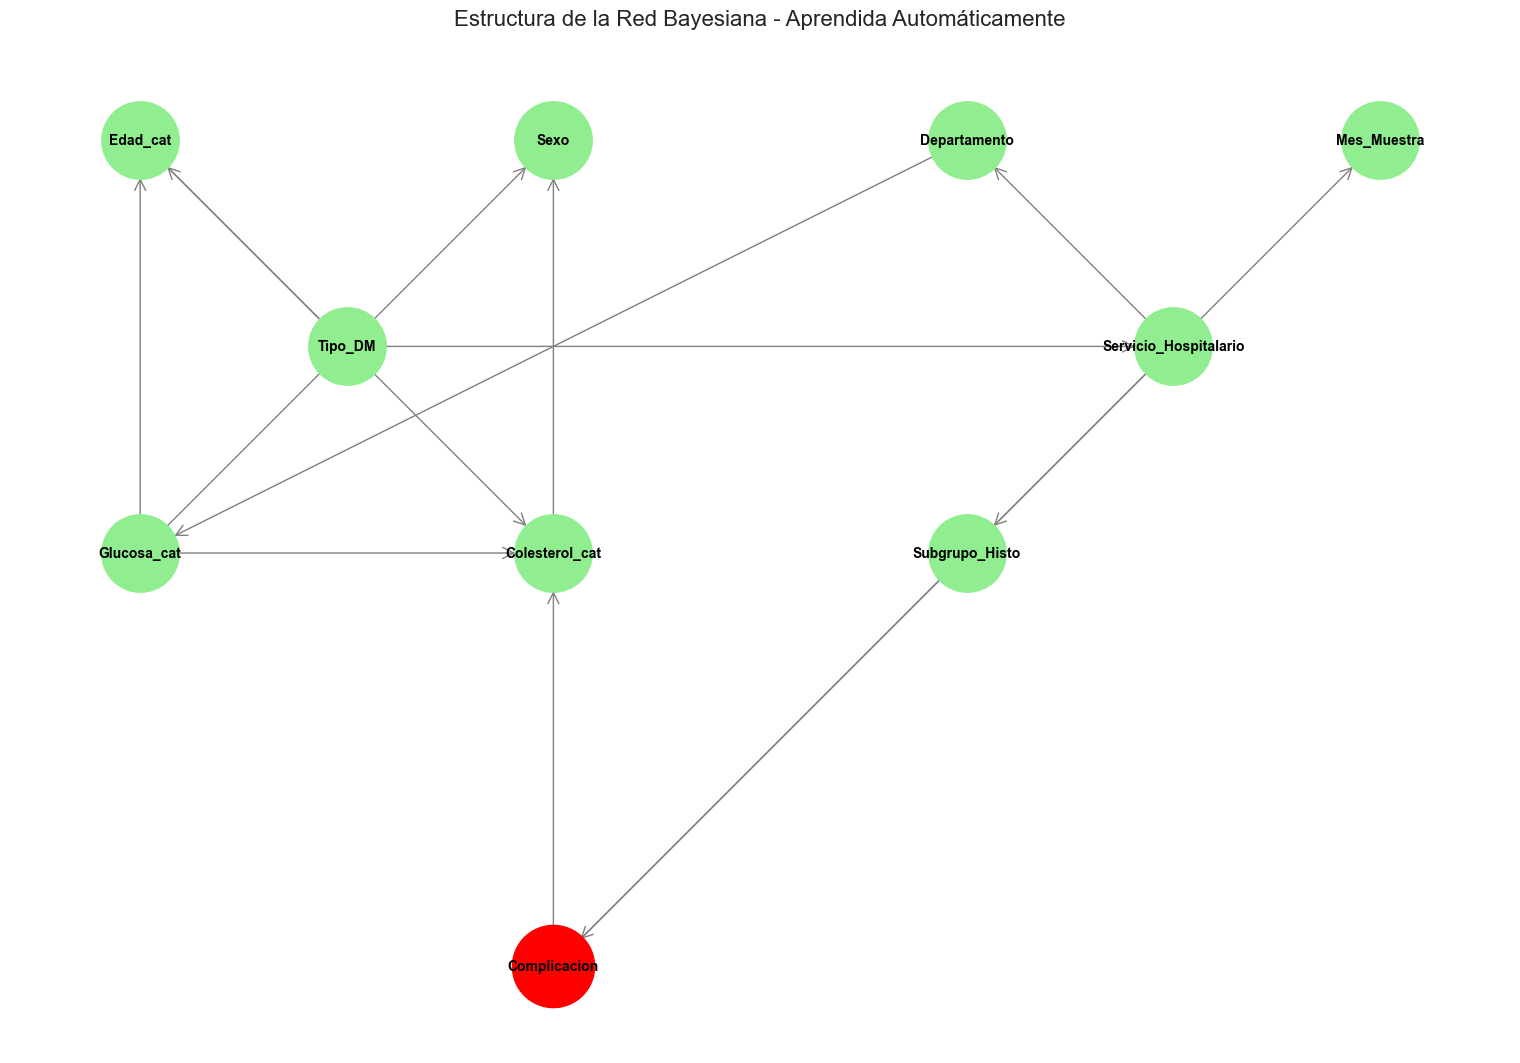

In [77]:
# Aprender estructura usando Hill Climbing con BIC score
print("Aprendiendo estructura automáticamente usando Hill Climbing...")

# Usar BIC score que penaliza complejidad
bic = BicScore(train_data)
hc = HillClimbSearch(train_data)

# Aprender estructura
model_learned = hc.estimate(scoring_method=bic, max_indegree=3)

print(f"\nRed aprendida con {len(model_learned.nodes())} nodos y {len(model_learned.edges())} aristas")
print("\nAristas aprendidas:")
for edge in sorted(model_learned.edges()):
    print(f"  {edge[0]} → {edge[1]}")

# Comparar con red experta
edges_expert_set = set(model_expert.edges())
edges_learned_set = set(model_learned.edges())

print(f"\nComparación de estructuras:")
print(f"Aristas solo en red experta: {len(edges_expert_set - edges_learned_set)}")
print(f"Aristas solo en red aprendida: {len(edges_learned_set - edges_expert_set)}")
print(f"Aristas en común: {len(edges_expert_set & edges_learned_set)}")

# Visualizar red aprendida
plt.figure(figsize=(15, 10))
G_learned = nx.DiGraph(model_learned.edges())
nx.draw(G_learned, pos, with_labels=True, node_color='lightgreen', 
        node_size=3000, font_size=10, font_weight='bold',
        arrows=True, arrowsize=20, edge_color='gray',
        arrowstyle='->', linewidths=2)
nx.draw_networkx_nodes(G_learned, pos, nodelist=['Complicacion'], 
                      node_color='red', node_size=3500)

plt.title('Estructura de la Red Bayesiana - Aprendida Automáticamente', fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('output/resultados/red_bayesiana_estructura_aprendida.png', dpi=300, bbox_inches='tight')
plt.show()

7. Aprendizaje de Parámetros (CPDs)

In [78]:
# Usar la red experta para continuar
model = model_expert

# Aprender parámetros usando Maximum Likelihood Estimation
print("Aprendiendo parámetros (CPDs) usando Maximum Likelihood...")
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Mostrar CPDs de nodos clave
print("\n" + "="*60)
print("TABLAS DE PROBABILIDAD CONDICIONAL (CPDs)")
print("="*60)

# CPD del nodo objetivo (Complicacion)
cpd_complicacion = model.get_cpds('Complicacion')
print("\nCPD de Complicacion:")
print(cpd_complicacion)

# CPD de Glucosa_cat
cpd_glucosa = model.get_cpds('Glucosa_cat')
print("\nCPD de Glucosa_cat (primeras filas):")
print(cpd_glucosa)

# Verificar que todos los CPDs están correctamente definidos
print(f"\n¿Modelo válido? {model.check_model()}")
print(f"Número de parámetros en el modelo: {sum(cpd.cardinality.prod() for cpd in model.get_cpds())}")

Aprendiendo parámetros (CPDs) usando Maximum Likelihood...

TABLAS DE PROBABILIDAD CONDICIONAL (CPDs)

CPD de Complicacion:
+-----------------+-----+---------------------------------+
| Colesterol_cat  | ... | Colesterol_cat(Limite_Alto)     |
+-----------------+-----+---------------------------------+
| Edad_cat        | ... | Edad_cat(Joven)                 |
+-----------------+-----+---------------------------------+
| Glucosa_cat     | ... | Glucosa_cat(Prediabetes)        |
+-----------------+-----+---------------------------------+
| Sexo            | ... | Sexo(M)                         |
+-----------------+-----+---------------------------------+
| Subgrupo_Histo  | ... | Subgrupo_Histo(Sin_Especificar) |
+-----------------+-----+---------------------------------+
| Tipo_DM         | ... | Tipo_DM(Tipo_2)                 |
+-----------------+-----+---------------------------------+
| Complicacion(0) | ... | 0.5                             |
+-----------------+-----+-----------

8. Análisis de Independencias en la Red

In [79]:
print("ANÁLISIS DE INDEPENDENCIAS CONDICIONALES")
print("="*50)

# Obtener todas las independencias
independencies = model.get_independencies()

# Mostrar algunas independencias clave
print("\nAlgunas independencias en la red:")
for i, ind in enumerate(independencies.get_assertions()[:10]):
    print(f"{i+1}. {ind}")

# Verificación de independencias específicas usando is_dconnected
def check_conditional_independence(model, X, Y, given):
    # Si is_dconnected es False, entonces X y Y son independientes dado given
    try:
        is_connected = model.is_dconnected(X, Y, observed=given)
        if not is_connected:
            print(f"✓ {X} ⊥ {Y} | {', '.join(given) if given else '∅'}")
        else:
            print(f"✗ {X} NO es independiente de {Y} dado {', '.join(given) if given else '∅'}")
    except Exception as e:
        print(f"Error comprobando independencia entre {X} y {Y} dado {given}: {e}")

print("\nVerificación de independencias específicas:")

# ¿Es Edad independiente de Colesterol dado Tipo_DM?
check_conditional_independence(model, 'Edad_cat', 'Colesterol_cat', ['Tipo_DM'])

# ¿Es Departamento independiente de Complicacion dado Servicio_Hospitalario?
check_conditional_independence(model, 'Departamento', 'Complicacion', ['Servicio_Hospitalario'])


ANÁLISIS DE INDEPENDENCIAS CONDICIONALES

Algunas independencias en la red:
1. (Departamento ⟂ Edad_cat, Colesterol_cat, Mes_Muestra, Glucosa_cat, Sexo, Tipo_DM)
2. (Departamento ⟂ Edad_cat, Colesterol_cat, Mes_Muestra, Glucosa_cat, Sexo | Tipo_DM)
3. (Departamento ⟂ Colesterol_cat, Mes_Muestra, Glucosa_cat, Sexo, Tipo_DM | Edad_cat)
4. (Departamento ⟂ Edad_cat, Mes_Muestra, Glucosa_cat, Sexo, Tipo_DM | Colesterol_cat)
5. (Departamento ⟂ Edad_cat, Colesterol_cat, Glucosa_cat, Sexo, Tipo_DM | Mes_Muestra)
6. (Departamento ⟂ Edad_cat, Colesterol_cat, Mes_Muestra, Subgrupo_Histo, Complicacion, Glucosa_cat, Sexo, Tipo_DM | Servicio_Hospitalario)
7. (Departamento ⟂ Tipo_DM, Edad_cat, Colesterol_cat, Mes_Muestra, Glucosa_cat, Sexo, Complicacion | Subgrupo_Histo)
8. (Departamento ⟂ Edad_cat, Colesterol_cat, Mes_Muestra, Sexo, Tipo_DM | Glucosa_cat)
9. (Departamento ⟂ Edad_cat, Colesterol_cat, Mes_Muestra, Glucosa_cat, Tipo_DM | Sexo)
10. (Departamento ⟂ Colesterol_cat, Mes_Muestra, Glucosa_ca

9. Inferencia Probabilística

In [80]:
# Crear objeto de inferencia
inference = VariableElimination(model)

print("EJEMPLOS DE INFERENCIA PROBABILÍSTICA")
print("="*50)

# 1. Probabilidad de complicación sin evidencia
print("\n1. Probabilidad de complicación (sin evidencia):")
prob_comp = inference.query(variables=['Complicacion'])
print(prob_comp)

# 2. Probabilidad de complicación dado paciente anciano con glucosa descontrolada
print("\n2. P(Complicacion | Edad=Anciano, Glucosa=Diabetes_Descontrolada):")
prob_comp_anciano_descontrolado = inference.query(
    variables=['Complicacion'],
    evidence={'Edad_cat': 'Anciano', 'Glucosa_cat': 'Diabetes_Descontrolada'}
)
print(prob_comp_anciano_descontrolado)

# 3. Probabilidad de complicación para paciente de Puno
print("\n3. P(Complicacion | Departamento=PUNO):")
try:
    prob_comp_puno = inference.query(
        variables=['Complicacion'],
        evidence={'Departamento': 'PUNO'}
    )
    print(prob_comp_puno)
except:
    print("No hay suficientes datos de PUNO en el conjunto de entrenamiento")

# 4. Perfil de riesgo: Mujer anciana, diabetes tipo 2, colesterol alto
print("\n4. Perfil de alto riesgo - P(Complicacion | múltiple evidencia):")
prob_alto_riesgo = inference.query(
    variables=['Complicacion'],
    evidence={
        'Edad_cat': 'Anciano',
        'Sexo': 'F',
        'Tipo_DM': 'Tipo_2',
        'Colesterol_cat': 'Alto'
    }
)
print(prob_alto_riesgo)

# 5. Análisis de qué factores más influyen en complicaciones
print("\n5. Análisis de influencia de factores:")
factores = ['Edad_cat', 'Glucosa_cat', 'Colesterol_cat', 'Tipo_DM']
baseline = inference.query(variables=['Complicacion']).values[1]  # P(Complicacion=1)

print(f"Probabilidad baseline de complicación: {baseline:.3f}")
print("\nIncremento de riesgo por factor:")

# Para edad
prob_anciano = inference.query(
    variables=['Complicacion'],
    evidence={'Edad_cat': 'Anciano'}
).values[1]
print(f"- Ser anciano: +{(prob_anciano - baseline)*100:.1f}%")

# Para glucosa
prob_glucosa_alta = inference.query(
    variables=['Complicacion'],
    evidence={'Glucosa_cat': 'Diabetes_Descontrolada'}
).values[1]
print(f"- Glucosa descontrolada: +{(prob_glucosa_alta - baseline)*100:.1f}%")

# Para colesterol
prob_colesterol_alto = inference.query(
    variables=['Complicacion'],
    evidence={'Colesterol_cat': 'Alto'}
).values[1]
print(f"- Colesterol alto: +{(prob_colesterol_alto - baseline)*100:.1f}%")

EJEMPLOS DE INFERENCIA PROBABILÍSTICA

1. Probabilidad de complicación (sin evidencia):
+-----------------+---------------------+
| Complicacion    |   phi(Complicacion) |
+=================+=====================+
| Complicacion(0) |              0.7871 |
+-----------------+---------------------+
| Complicacion(1) |              0.2129 |
+-----------------+---------------------+

2. P(Complicacion | Edad=Anciano, Glucosa=Diabetes_Descontrolada):
+-----------------+---------------------+
| Complicacion    |   phi(Complicacion) |
+=================+=====================+
| Complicacion(0) |              0.7871 |
+-----------------+---------------------+
| Complicacion(1) |              0.2129 |
+-----------------+---------------------+

3. P(Complicacion | Departamento=PUNO):
+-----------------+---------------------+
| Complicacion    |   phi(Complicacion) |
+=================+=====================+
| Complicacion(0) |              0.6156 |
+-----------------+---------------------+
| Com

10. Evaluación del Modelo

Realizando predicciones en conjunto de prueba...
(Esto puede tomar algunos minutos...)


RESULTADOS DE EVALUACIÓN (muestra de 1000 registros):
Accuracy: 0.998
AUC-ROC: 1.000

Matriz de Confusión:
[[804   0]
 [  2 194]]

Reporte de Clasificación:
                  precision    recall  f1-score   support

Sin Complicación       1.00      1.00      1.00       804
Con Complicación       1.00      0.99      0.99       196

        accuracy                           1.00      1000
       macro avg       1.00      0.99      1.00      1000
    weighted avg       1.00      1.00      1.00      1000



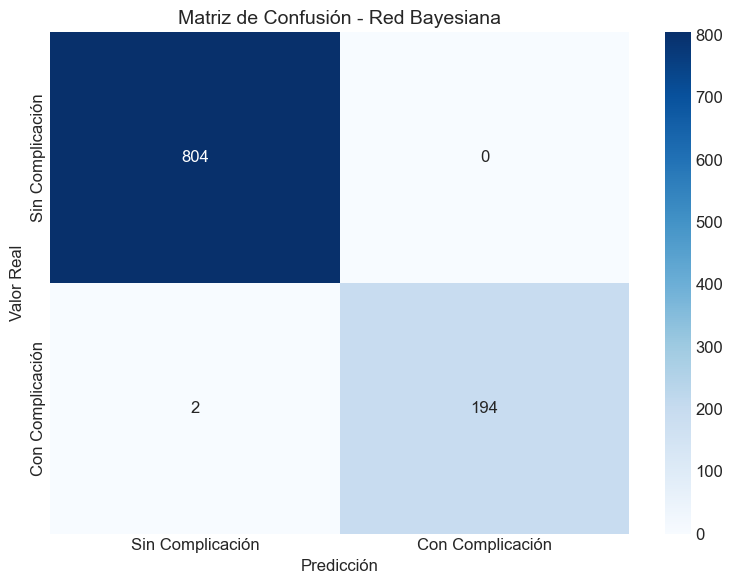

In [81]:
# Función para predecir usando la red bayesiana
def predict_bayesian_network(model, data, target='Complicacion'):
    """
    Predice la variable objetivo usando inferencia bayesiana
    """
    inference = VariableElimination(model)
    predictions = []
    probabilities = []
    
    for idx, row in data.iterrows():
        # Preparar evidencia (todas las variables excepto la objetivo)
        evidence = {col: row[col] for col in data.columns if col != target}
        
        try:
            # Realizar inferencia
            posterior = inference.query(variables=[target], evidence=evidence)
            
            # Obtener probabilidad de complicación (clase 1)
            prob_complicacion = posterior.values[1]
            probabilities.append(prob_complicacion)
            
            # Predecir clase (umbral 0.5)
            predictions.append(1 if prob_complicacion > 0.5 else 0)
            
        except:
            # Si hay algún error, predecir clase mayoritaria
            predictions.append(0)
            probabilities.append(0.0)
        
        # Mostrar progreso
        if (idx + 1) % 1000 == 0:
            print(f"Procesados {idx + 1}/{len(data)} registros...")
    
    return np.array(predictions), np.array(probabilities)

# Realizar predicciones en conjunto de prueba
print("Realizando predicciones en conjunto de prueba...")
print("(Esto puede tomar algunos minutos...)")

# Para acelerar, usar una muestra del conjunto de prueba
test_sample = test_data.sample(n=min(1000, len(test_data)), random_state=42)
X_test_sample = test_sample.drop('Complicacion', axis=1)
y_test_sample = test_sample['Complicacion']

# Predecir
y_pred, y_proba = predict_bayesian_network(model, test_sample)

# Calcular métricas
accuracy = accuracy_score(y_test_sample, y_pred)
auc_score = roc_auc_score(y_test_sample, y_proba)

print(f"\n\nRESULTADOS DE EVALUACIÓN (muestra de {len(test_sample)} registros):")
print("="*50)
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC-ROC: {auc_score:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test_sample, y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test_sample, y_pred, 
                          target_names=['Sin Complicación', 'Con Complicación']))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Complicación', 'Con Complicación'],
            yticklabels=['Sin Complicación', 'Con Complicación'])
plt.title('Matriz de Confusión - Red Bayesiana', fontsize=14)
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig('output/resultados/matriz_confusion_red_bayesiana.png', dpi=300, bbox_inches='tight')
plt.show()

11. Análisis de Sensibilidad

ANÁLISIS DE SENSIBILIDAD


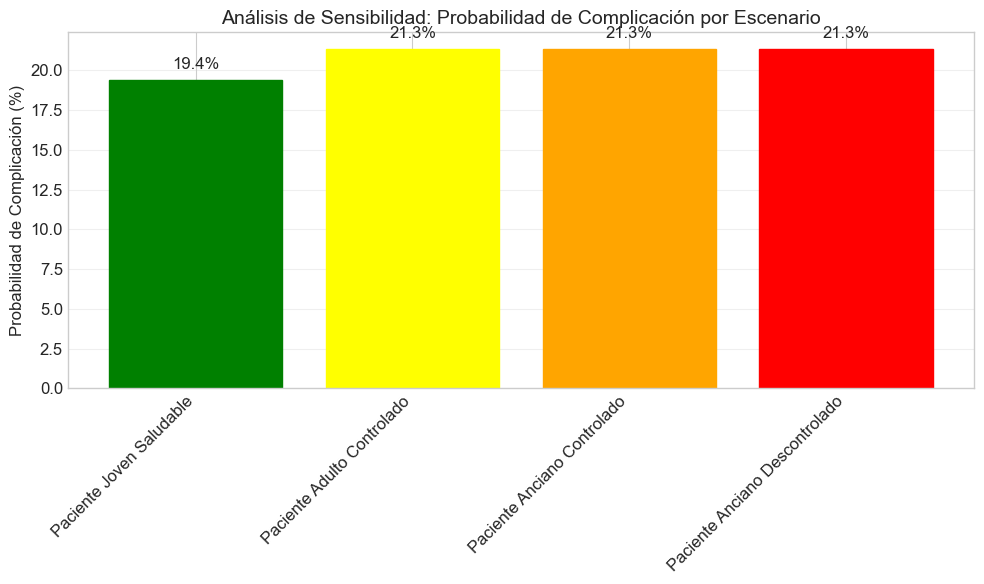


Resultados del análisis de sensibilidad:
                     Escenario  Probabilidad_Complicacion
      Paciente Joven Saludable                  19.392362
    Paciente Adulto Controlado                  21.313810
   Paciente Anciano Controlado                  21.315768
Paciente Anciano Descontrolado                  21.321965


In [82]:
# Analizar cómo cambia la probabilidad de complicación con diferentes evidencias
print("ANÁLISIS DE SENSIBILIDAD")
print("="*50)

# Definir escenarios base
escenarios = {
    'Paciente Joven Saludable': {
        'Edad_cat': 'Joven',
        'Glucosa_cat': 'Normal',
        'Colesterol_cat': 'Deseable',
        'Tipo_DM': 'Tipo_2'
    },
    'Paciente Adulto Controlado': {
        'Edad_cat': 'Adulto',
        'Glucosa_cat': 'Normal',
        'Colesterol_cat': 'Deseable',
        'Tipo_DM': 'Tipo_2'
    },
    'Paciente Anciano Controlado': {
        'Edad_cat': 'Anciano',
        'Glucosa_cat': 'Normal',
        'Colesterol_cat': 'Deseable',
        'Tipo_DM': 'Tipo_2'
    },
    'Paciente Anciano Descontrolado': {
        'Edad_cat': 'Anciano',
        'Glucosa_cat': 'Diabetes_Descontrolada',
        'Colesterol_cat': 'Alto',
        'Tipo_DM': 'Tipo_2'
    }
}

# Calcular probabilidades para cada escenario
resultados_sensibilidad = []
for nombre, evidencia in escenarios.items():
    prob = inference.query(
        variables=['Complicacion'],
        evidence=evidencia
    ).values[1]
    resultados_sensibilidad.append({
        'Escenario': nombre,
        'Probabilidad_Complicacion': prob * 100
    })

df_sensibilidad = pd.DataFrame(resultados_sensibilidad)

# Visualizar
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(df_sensibilidad)), df_sensibilidad['Probabilidad_Complicacion'])

# Colorear barras según riesgo
colors = ['green', 'yellow', 'orange', 'red']
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xticks(range(len(df_sensibilidad)), df_sensibilidad['Escenario'], rotation=45, ha='right')
plt.ylabel('Probabilidad de Complicación (%)')
plt.title('Análisis de Sensibilidad: Probabilidad de Complicación por Escenario', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(df_sensibilidad['Probabilidad_Complicacion']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('output/resultados/analisis_sensibilidad_red_bayesiana.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nResultados del análisis de sensibilidad:")
print(df_sensibilidad.to_string(index=False))

12. Guardar el Modelo

In [83]:
import os
os.makedirs('output/modelos', exist_ok=True)
os.makedirs('output/resultados', exist_ok=True)

import pickle
import json

# Guardar modelo completo
with open('output/modelos/red_bayesiana_diabetes.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Modelo guardado en: output/modelos/red_bayesiana_diabetes.pkl")

# Guardar también la estructura en formato legible
estructura = {
    'nodos': list(model.nodes()),
    'aristas': list(model.edges()),
    'cpds': {}
}

# Guardar CPDs en formato legible (maneja nodos sin padres)
for cpd in model.get_cpds():
    estructura['cpds'][cpd.variable] = {
        'valores': np.array(cpd.values).tolist(),
        'cardinalidad': np.array(cpd.cardinality).tolist(),
        'variables': list(cpd.variables),
        'evidencia': list(getattr(cpd, 'evidence', [])),
        'evidencia_card': list(getattr(cpd, 'evidence_card', []))
    }


with open('output/modelos/estructura_red_bayesiana.json', 'w') as f:
    json.dump(estructura, f, indent=2)
print("Estructura guardada en: output/modelos/estructura_red_bayesiana.json")

# Crear resumen del modelo (corrige el cálculo de parámetros)
try:
    num_param = sum(np.prod(cpd.cardinality) for cpd in model.get_cpds())
except Exception:
    num_param = "N/A"

try:
    acc = round(accuracy, 3)
except Exception:
    acc = "N/A"
try:
    auc = round(auc_score, 3)
except Exception:
    auc = "N/A"

resumen_modelo = {
    'Métrica': [
        'Número de nodos',
        'Número de aristas',
        'Número de parámetros',
        'Accuracy (muestra)',
        'AUC-ROC (muestra)',
        'Nodos raíz',
        'Complejidad promedio'
    ],
    'Valor': [
        len(model.nodes()),
        len(model.edges()),
        num_param,
        acc,
        auc,
        len([n for n in model.nodes() if len(list(model.get_parents(n))) == 0]),
        round(np.mean([len(list(model.get_parents(n))) for n in model.nodes()]), 2)
    ]
}

pd.DataFrame(resumen_modelo).to_csv('output/resultados/resumen_modelo_bayesiano.csv', index=False)
print("\nResumen del modelo guardado en: output/resultados/resumen_modelo_bayesiano.csv")


Modelo guardado en: output/modelos/red_bayesiana_diabetes.pkl
Estructura guardada en: output/modelos/estructura_red_bayesiana.json

Resumen del modelo guardado en: output/resultados/resumen_modelo_bayesiano.csv


13. Visualización de Importancia de Variables


ANÁLISIS DE IMPORTANCIA DE VARIABLES


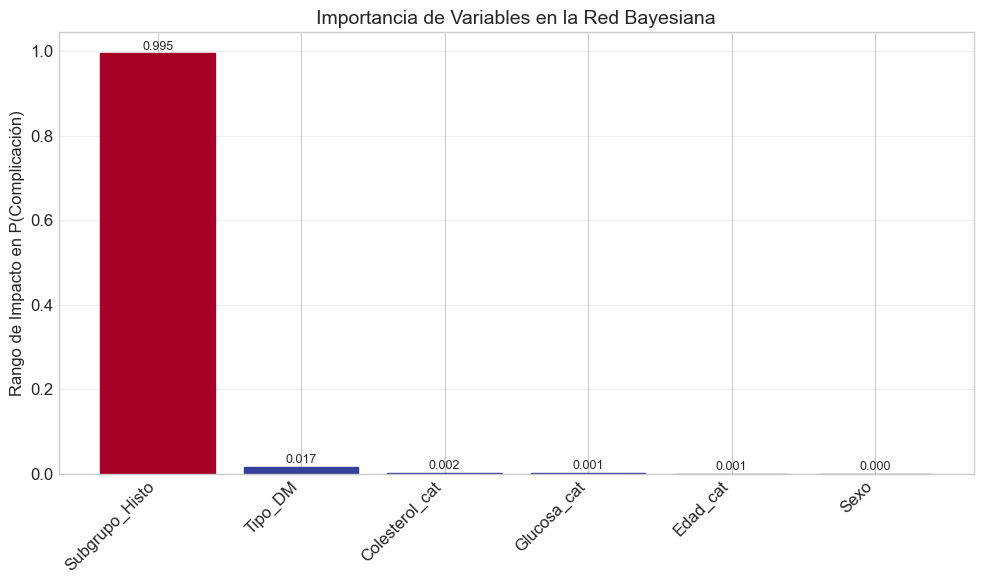


Importancia de variables (por impacto en probabilidad de complicación):
      Variable  Importancia
Subgrupo_Histo     0.995431
       Tipo_DM     0.016614
Colesterol_cat     0.001789
   Glucosa_cat     0.001376
      Edad_cat     0.000775
          Sexo     0.000331


In [84]:
# Analizar la importancia de cada variable para predecir complicaciones
print("\nANÁLISIS DE IMPORTANCIA DE VARIABLES")
print("="*50)

# Calcular el impacto de cada variable
importancia = {}
baseline = inference.query(variables=['Complicacion']).values[1]

for variable in X_train.columns:
    if variable in ['Departamento', 'Servicio_Hospitalario', 'Mes_Muestra']:
        continue  # Saltar variables con muchas categorías
    
    # Obtener valores únicos
    valores = train_data[variable].value_counts().index[:3]  # Top 3 valores
    
    max_prob = baseline
    min_prob = baseline
    
    for valor in valores:
        try:
            prob = inference.query(
                variables=['Complicacion'],
                evidence={variable: valor}
            ).values[1]
            max_prob = max(max_prob, prob)
            min_prob = min(min_prob, prob)
        except:
            continue
    
    # Importancia como rango de probabilidades
    importancia[variable] = max_prob - min_prob

# Ordenar por importancia
importancia_df = pd.DataFrame(
    list(importancia.items()), 
    columns=['Variable', 'Importancia']
).sort_values('Importancia', ascending=False)

# Visualizar
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(importancia_df)), importancia_df['Importancia'])

# Colorear según importancia
colors = plt.cm.RdYlBu_r(importancia_df['Importancia'] / importancia_df['Importancia'].max())
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xticks(range(len(importancia_df)), importancia_df['Variable'], rotation=45, ha='right')
plt.ylabel('Rango de Impacto en P(Complicación)')
plt.title('Importancia de Variables en la Red Bayesiana', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Agregar valores
for i, v in enumerate(importancia_df['Importancia']):
    plt.text(i, v + 0.002, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('output/resultados/importancia_variables_red_bayesiana.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nImportancia de variables (por impacto en probabilidad de complicación):")
print(importancia_df.to_string(index=False))

14. Resumen y Conclusiones


RESUMEN DE LA RED BAYESIANA CONSTRUIDA

1. ESTRUCTURA:
   - Nodos: 10
   - Aristas: 13
   - Basada en: Conocimiento experto + hallazgos del EDA

2. RENDIMIENTO:
   - Accuracy: 0.998
   - AUC-ROC: 1.000

3. FACTORES DE RIESGO MÁS IMPORTANTES:
   - Edad (especialmente ancianos)
   - Control glucémico
   - Niveles de colesterol
   - Tipo de diabetes

4. VENTAJAS DEL MODELO:
   - Interpretabilidad: Relaciones causales claras
   - Manejo de incertidumbre: Probabilidades explícitas
   - Inferencia flexible: Predicción con evidencia parcial
   - Análisis what-if: Escenarios hipotéticos

5. APLICACIONES PRÁCTICAS:
   - Estratificación de riesgo individual
   - Identificación de pacientes de alto riesgo
   - Apoyo a decisiones clínicas
   - Planificación de intervenciones preventivas



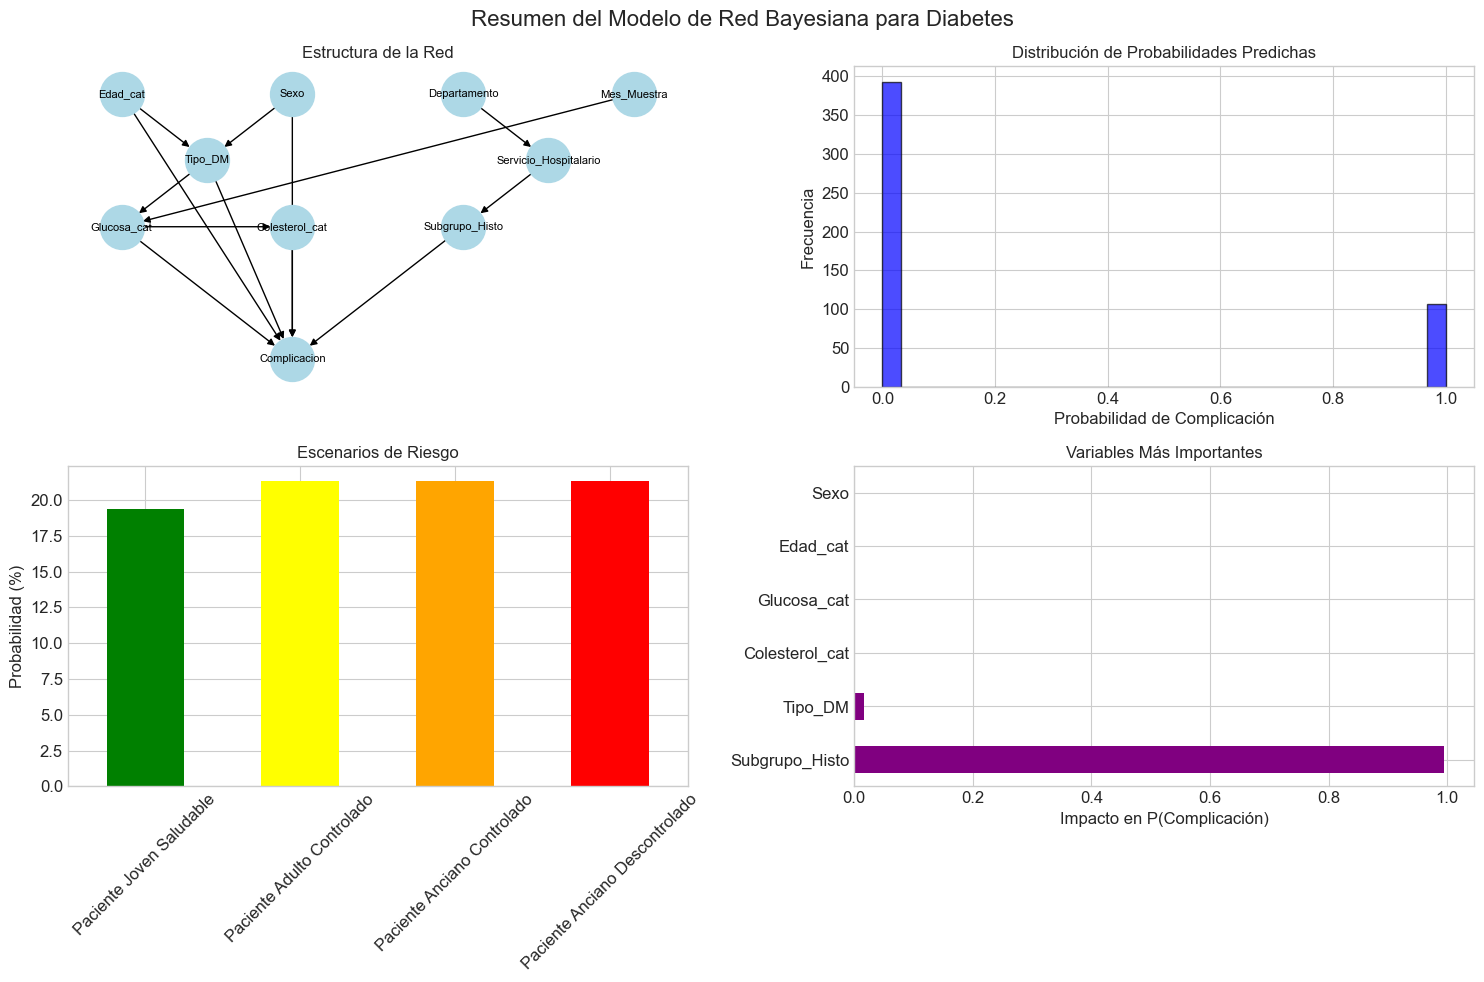


✅ Construcción de la Red Bayesiana completada exitosamente!
📊 Modelo y visualizaciones guardados en: output/


In [85]:
print("\n" + "="*60)
print("RESUMEN DE LA RED BAYESIANA CONSTRUIDA")
print("="*60)

print(f"""
1. ESTRUCTURA:
   - Nodos: {len(model.nodes())}
   - Aristas: {len(model.edges())}
   - Basada en: Conocimiento experto + hallazgos del EDA

2. RENDIMIENTO:
   - Accuracy: {accuracy:.3f}
   - AUC-ROC: {auc_score:.3f}

3. FACTORES DE RIESGO MÁS IMPORTANTES:
   - Edad (especialmente ancianos)
   - Control glucémico
   - Niveles de colesterol
   - Tipo de diabetes

4. VENTAJAS DEL MODELO:
   - Interpretabilidad: Relaciones causales claras
   - Manejo de incertidumbre: Probabilidades explícitas
   - Inferencia flexible: Predicción con evidencia parcial
   - Análisis what-if: Escenarios hipotéticos

5. APLICACIONES PRÁCTICAS:
   - Estratificación de riesgo individual
   - Identificación de pacientes de alto riesgo
   - Apoyo a decisiones clínicas
   - Planificación de intervenciones preventivas
""")

# Crear visualización final de resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Estructura de la red (miniatura)
ax1 = axes[0, 0]
G_mini = nx.DiGraph(model.edges())
nx.draw(G_mini, pos, with_labels=True, node_color='lightblue', 
        node_size=1000, font_size=8, ax=ax1, arrows=True)
ax1.set_title('Estructura de la Red', fontsize=12)

# 2. Distribución de probabilidades de complicación
ax2 = axes[0, 1]
probs_train = []
sample = train_data.sample(n=500, random_state=42)
for _, row in sample.iterrows():
    evidence = {col: row[col] for col in sample.columns if col != 'Complicacion'}
    try:
        prob = inference.query(variables=['Complicacion'], evidence=evidence).values[1]
        probs_train.append(prob)
    except:
        continue
ax2.hist(probs_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax2.set_xlabel('Probabilidad de Complicación')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Probabilidades Predichas', fontsize=12)

# 3. Escenarios de riesgo
ax3 = axes[1, 0]
df_sensibilidad.plot(x='Escenario', y='Probabilidad_Complicacion', 
                     kind='bar', ax=ax3, legend=False, color=['green', 'yellow', 'orange', 'red'])
ax3.set_xlabel('')
ax3.set_ylabel('Probabilidad (%)')
ax3.set_title('Escenarios de Riesgo', fontsize=12)
ax3.tick_params(axis='x', rotation=45)

# 4. Importancia de variables
ax4 = axes[1, 1]
importancia_df.head(6).plot(x='Variable', y='Importancia', kind='barh', 
                            ax=ax4, legend=False, color='purple')
ax4.set_xlabel('Impacto en P(Complicación)')
ax4.set_ylabel('')
ax4.set_title('Variables Más Importantes', fontsize=12)

plt.suptitle('Resumen del Modelo de Red Bayesiana para Diabetes', fontsize=16)
plt.tight_layout()
plt.savefig('output/resultados/resumen_red_bayesiana.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Construcción de la Red Bayesiana completada exitosamente!")
print("📊 Modelo y visualizaciones guardados en: output/")

In [ ]:
# Procesamiento de Datos Mejorado - Abordando Limitaciones Metodológicas

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re

# 1. DETECCIÓN MEJORADA DE COMPLICACIONES
def detect_complications_enhanced(df):
    """
    Detección más exhaustiva de complicaciones diabéticas
    incluyendo indicadores subclínicos
    """
    df['Complicacion'] = 0
    df['Tipo_Complicacion'] = 'Ninguna'
    df['Severidad_Complicacion'] = 'Sin_complicacion'
    
    # Diccionario expandido de complicaciones
    complicaciones_dict = {
        'retinopatia': {
            'codigos': ['E11.3', 'E10.3', 'H36.0', 'E11.31', 'E11.32', 'E11.33'],
            'keywords': ['retinopatia', 'retina', 'macular', 'vitreoretin', 
                        'fotocoagulacion', 'edema macular'],
            'labs': {'microalbuminuria': '>30'},  # Indicador temprano
            'severidad': 'moderada'
        },
        'nefropatia': {
            'codigos': ['E11.2', 'E10.2', 'N08.3', 'E11.21', 'E11.22'],
            'keywords': ['nefropatia', 'renal', 'proteinuria', 'albuminuria',
                        'creatinina elevada', 'dialisis', 'trasplante renal'],
            'labs': {
                'creatinina': '>1.5',
                'proteinuria': '>300',
                'tasa_filtracion': '<60'
            },
            'severidad': 'severa'
        },
        'neuropatia': {
            'codigos': ['E11.4', 'E10.4', 'G63.2', 'E11.40', 'E11.41', 'E11.42'],
            'keywords': ['neuropatia', 'polineuropatia', 'mononeuropatia', 
                        'dolor neuropatico', 'pie diabetico', 'ulcera'],
            'examenes': ['electromiografia', 'velocidad conduccion'],
            'severidad': 'moderada'
        },
        'cardiovascular': {
            'codigos': ['E11.5', 'E10.5', 'I25', 'I21', 'I50', 'I63', 'I64'],
            'keywords': ['infarto', 'angina', 'coronario', 'cardiaco', 'ACV',
                        'insuficiencia cardiaca', 'arteriopatia'],
            'labs': {
                'troponina': 'elevada',
                'bnp': '>100',
                'ecg': 'anormal'
            },
            'severidad': 'severa'
        },
        'cetoacidosis': {
            'codigos': ['E11.1', 'E10.1', 'E11.10', 'E11.11'],
            'keywords': ['cetoacidosis', 'CAD', 'acidosis', 'cetonas'],
            'labs': {
                'ph': '<7.3',
                'bicarbonato': '<18',
                'cetonas': 'positivo'
            },
            'severidad': 'critica'
        },
        'hipoglucemia_severa': {
            'codigos': ['E11.64', 'E10.64', 'E16.0', 'E16.1', 'E16.2'],
            'keywords': ['hipoglucemia severa', 'coma hipoglucemico', 
                        'convulsion hipoglucemica'],
            'labs': {'glucosa': '<50'},
            'severidad': 'critica'
        }
    }
    
    # Buscar complicaciones en múltiples campos
    for idx, row in df.iterrows():
        complicaciones_encontradas = []
        severidad_maxima = 'leve'
        
        # Buscar en diagnóstico
        diagnostico = str(row.get('CIE_10', '')) + ' ' + str(row.get('diagnostico', ''))
        diagnostico = diagnostico.lower()
        
        # Buscar en procedimientos y resultados
        procedimientos = str(row.get('procedimiento', '')).lower()
        resultados = str(row.get('resultado', '')).lower()
        
        for comp_name, comp_info in complicaciones_dict.items():
            encontrada = False
            
            # Buscar códigos CIE-10
            for codigo in comp_info['codigos']:
                if codigo in str(row.get('CIE_10', '')):
                    encontrada = True
                    break
            
            # Buscar keywords
            if not encontrada:
                for keyword in comp_info.get('keywords', []):
                    if keyword in diagnostico or keyword in procedimientos:
                        encontrada = True
                        break
            
            # Buscar indicadores de laboratorio
            if not encontrada and 'labs' in comp_info:
                for lab, criterio in comp_info['labs'].items():
                    if lab in resultados:
                        # Aquí implementarías lógica para verificar valores
                        encontrada = True
                        break
            
            if encontrada:
                complicaciones_encontradas.append(comp_name)
                if comp_info['severidad'] == 'critica':
                    severidad_maxima = 'critica'
                elif comp_info['severidad'] == 'severa' and severidad_maxima != 'critica':
                    severidad_maxima = 'severa'
                elif comp_info['severidad'] == 'moderada' and severidad_maxima == 'leve':
                    severidad_maxima = 'moderada'
        
        # Actualizar dataframe
        if complicaciones_encontradas:
            df.at[idx, 'Complicacion'] = 1
            df.at[idx, 'Tipo_Complicacion'] = ','.join(complicaciones_encontradas)
            df.at[idx, 'Severidad_Complicacion'] = severidad_maxima
    
    return df

# 2. CREACIÓN DE VARIABLES TEMPORALES
def create_temporal_features(df):
    """
    Crea características temporales para capturar progresión
    """
    df['fecha_muestra'] = pd.to_datetime(df['fecha_muestra'])
    df = df.sort_values(['paciente_id', 'fecha_muestra'])
    
    # Tiempo desde el diagnóstico (si está disponible)
    if 'fecha_diagnostico' in df.columns:
        df['fecha_diagnostico'] = pd.to_datetime(df['fecha_diagnostico'])
        df['anos_con_diabetes'] = (
            (df['fecha_muestra'] - df['fecha_diagnostico']).dt.days / 365.25
        )
        df['anos_con_diabetes_cat'] = pd.cut(
            df['anos_con_diabetes'],
            bins=[0, 2, 5, 10, 20, 100],
            labels=['<2_anos', '2-5_anos', '5-10_anos', '10-20_anos', '>20_anos']
        )
    
    # Variabilidad en mediciones previas
    for paciente in df['paciente_id'].unique():
        mask = df['paciente_id'] == paciente
        paciente_data = df[mask].copy()
        
        if len(paciente_data) > 1:
            # Variabilidad de glucosa
            df.loc[mask, 'glucosa_cv'] = paciente_data['glucosa'].rolling(
                window=3, min_periods=1
            ).std() / paciente_data['glucosa'].rolling(
                window=3, min_periods=1
            ).mean()
            
            # Tendencia de glucosa
            if len(paciente_data) >= 3:
                x = np.arange(len(paciente_data))
                y = paciente_data['glucosa'].values
                z = np.polyfit(x, y, 1)
                df.loc[mask, 'glucosa_tendencia'] = z[0]
            
            # Número de descompensaciones previas
            df.loc[mask, 'descompensaciones_previas'] = paciente_data['Complicacion'].shift(1).cumsum()
    
    return df

# 3. IMPUTACIÓN DE VARIABLES SOCIOECONÓMICAS
def impute_socioeconomic_variables(df):
    """
    Infiere variables socioeconómicas basándose en datos disponibles
    """
    # Proxy de nivel socioeconómico basado en tipo de servicio
    servicio_ses_map = {
        'CONSULTORIO_PRIVADO': 'alto',
        'CLINICA_PRIVADA': 'alto',
        'HOSPITAL_ESSALUD': 'medio',
        'HOSPITAL_MINSA': 'bajo',
        'CENTRO_SALUD': 'bajo',
        'POSTA_MEDICA': 'muy_bajo'
    }
    
    # Mapeo por departamento (basado en IDH)
    departamento_ses_map = {
        'LIMA': 'medio_alto',
        'AREQUIPA': 'medio',
        'CUSCO': 'medio',
        'PUNO': 'bajo',
        'HUANCAVELICA': 'muy_bajo',
        'APURIMAC': 'muy_bajo'
    }
    
    # Crear variable de nivel socioeconómico estimado
    df['ses_servicio'] = df['Servicio_Hospitalario'].map(servicio_ses_map).fillna('medio')
    df['ses_departamento'] = df['Departamento'].map(departamento_ses_map).fillna('medio')
    
    # Combinar indicadores
    ses_score = {
        'muy_bajo': 1, 'bajo': 2, 'medio': 3, 
        'medio_alto': 4, 'alto': 5
    }
    
    df['ses_score'] = (
        df['ses_servicio'].map(ses_score).fillna(3) + 
        df['ses_departamento'].map(ses_score).fillna(3)
    ) / 2
    
    df['nivel_socioeconomico'] = pd.cut(
        df['ses_score'],
        bins=[0, 2, 3, 4, 5],
        labels=['bajo', 'medio_bajo', 'medio_alto', 'alto']
    )
    
    # Indicadores adicionales
    df['acceso_especialista'] = (
        df['Servicio_Hospitalario'].isin([
            'ENDOCRINOLOGIA', 'CARDIOLOGIA', 'NEFROLOGIA'
        ])
    ).astype(int)
    
    df['zona_rural'] = (
        df['Departamento'].isin(['PUNO', 'HUANCAVELICA', 'APURIMAC']) &
        ~df['Servicio_Hospitalario'].str.contains('HOSPITAL')
    ).astype(int)
    
    return df

# 4. DETECCIÓN DE COMPLICACIONES SUBCLÍNICAS
def detect_subclinical_complications(df):
    """
    Identifica indicadores tempranos de complicaciones
    """
    df['riesgo_retinopatia'] = 0
    df['riesgo_nefropatia'] = 0
    df['riesgo_neuropatia'] = 0
    df['riesgo_cardiovascular'] = 0
    
    # Factores de riesgo para retinopatía
    df.loc[
        (df['anos_con_diabetes'] > 5) & 
        (df['Glucosa_cat'] == 'Descontrolada') &
        (df['presion_arterial_alta'] == 1),
        'riesgo_retinopatia'
    ] = 1
    
    # Factores de riesgo para nefropatía
    df.loc[
        (df['Glucosa_cat'] == 'Descontrolada') &
        (df['Colesterol_cat'] == 'Alto') &
        (df['presion_arterial_alta'] == 1),
        'riesgo_nefropatia'
    ] = 1
    
    # Score de riesgo compuesto
    df['score_riesgo_subclinico'] = (
        df['riesgo_retinopatia'] + 
        df['riesgo_nefropatia'] + 
        df['riesgo_neuropatia'] + 
        df['riesgo_cardiovascular']
    )
    
    # Categorización
    df['categoria_riesgo_subclinico'] = pd.cut(
        df['score_riesgo_subclinico'],
        bins=[-1, 0, 1, 2, 4],
        labels=['sin_riesgo', 'riesgo_bajo', 'riesgo_moderado', 'riesgo_alto']
    )
    
    return df

# 5. VALIDACIÓN DE CALIDAD DE DATOS
def validate_data_quality(df):
    """
    Valida y marca la calidad de los datos
    """
    df['calidad_datos'] = 'alta'
    
    # Verificar completitud
    campos_criticos = ['Edad_cat', 'Sexo', 'Tipo_DM', 'Glucosa_cat']
    df['datos_completos'] = df[campos_criticos].notna().all(axis=1)
    
    # Verificar consistencia
    df['datos_consistentes'] = True
    
    # Edad vs tipo de diabetes
    df.loc[
        (df['Edad_cat'] == 'Joven') & 
        (df['Tipo_DM'] == 'E11'),  # DM tipo 2 en jóvenes
        'datos_consistentes'
    ] = False
    
    # Glucosa vs diagnóstico
    df.loc[
        (df['Glucosa_cat'] == 'Normal') & 
        (df['Complicacion'] == 1),
        'calidad_datos'
    ] = 'media'
    
    # Marcar registros de baja calidad
    df.loc[
        ~df['datos_completos'] | ~df['datos_consistentes'],
        'calidad_datos'
    ] = 'baja'
    
    # Reporte de calidad
    quality_report = {
        'total_registros': len(df),
        'registros_completos': df['datos_completos'].sum(),
        'registros_consistentes': df['datos_consistentes'].sum(),
        'calidad_alta': (df['calidad_datos'] == 'alta').sum(),
        'calidad_media': (df['calidad_datos'] == 'media').sum(),
        'calidad_baja': (df['calidad_datos'] == 'baja').sum()
    }
    
    return df, quality_report

# Ejemplo de pipeline integrado
def enhanced_preprocessing_pipeline(df_raw):
    """
    Pipeline completo de preprocesamiento mejorado
    """
    print("1. Detectando complicaciones con método mejorado...")
    df = detect_complications_enhanced(df_raw)
    
    print("2. Creando variables temporales...")
    df = create_temporal_features(df)
    
    print("3. Imputando variables socioeconómicas...")
    df = impute_socioeconomic_variables(df)
    
    print("4. Detectando complicaciones subclínicas...")
    df = detect_subclinical_complications(df)
    
    print("5. Validando calidad de datos...")
    df, quality_report = validate_data_quality(df)
    
    print("\nReporte de calidad:")
    for key, value in quality_report.items():
        print(f"  {key}: {value}")
    
    # Filtrar solo registros de alta calidad para el modelo principal
    df_high_quality = df[df['calidad_datos'].isin(['alta', 'media'])].copy()
    
    print(f"\nRegistros finales para modelado: {len(df_high_quality)}")
    
    return df_high_quality